# MNIST Hand Written Digit Recognition

Let's try using different machine learning models to address this problem and see which model gives the best accuracy in predicting hand written digits

Each digit is represented by a 28x28 pixels image.

# Imports

In [121]:
import matplotlib.pyplot as plt
%matplotlib inline
import math
import pandas as pd
import numpy as np
import json
import sklearn.datasets as datasets
from sklearn.datasets import fetch_openml
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import CategoricalNB
from sklearn.utils import shuffle,resample
from sklearn.metrics import jaccard_score,f1_score,accuracy_score,r2_score,silhouette_score,make_scorer
from sklearn.model_selection import train_test_split,GridSearchCV

# Preparing the datasets

Download the dataset from internet

In [2]:
rawdata = fetch_openml("mnist_784") # fetch dataset from internet

Getting the raw data X and Y from the downloaded dataset

In [3]:
x_raw,y_raw = np.asarray(rawdata['data']),np.asarray(rawdata['target'])

In [4]:
type(x_raw),x_raw.shape,x_raw.dtype,type(y_raw),y_raw.shape,y_raw.dtype

(numpy.ndarray,
 (70000, 784),
 dtype('float64'),
 numpy.ndarray,
 (70000,),
 dtype('O'))

In [5]:
x_train,x_test,y_train,y_test = train_test_split(x_raw,y_raw,test_size=1000,train_size=5000,random_state=1)

Changing the y datasets to dtype 'int'

In [6]:
y_train,y_test = y_train.astype(int),y_test.astype(int)

Let's have a look at some of the instances in the dataset we just loaded:

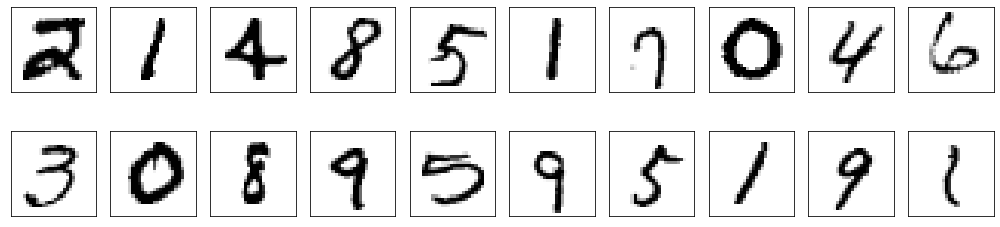

In [7]:
plt.figure(figsize=(14,4))
plt.rc("image", cmap="binary") # use black/white palette for plotting
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(x_train[i].reshape(28,28))
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()

## Storing Datasets

We will store our datasets locally so that we can continue with the same datasets everytime launching this notebook.\
The raw data will be stored as JSON file and the train and test datasets will be stored as CSV file.

In [31]:
pd.to_pickle(rawdata,"Datasets\\MNIST 784 rawdata.pkl",compression='zip')

In [94]:
pd.DataFrame(x_train).to_csv("Datasets\\x_train.csv")
pd.Series(y_train).to_csv("Datasets\\y_train.csv")
pd.DataFrame(x_test).to_csv("Datasets\\x_test.csv")
pd.Series(y_test).to_csv("Datasets\\y_test.csv")

## Loading Datasets

In [106]:
rawdata = pd.read_pickle("Datasets\\MNIST 784 rawdata.pkl",compression='zip')

In [107]:
type(rawdata)

sklearn.utils._bunch.Bunch

In [117]:
x_train = pd.read_csv("Datasets\\x_train.csv",index_col=0).values
y_train = pd.read_csv("Datasets\\y_train.csv",index_col=0)['0'].values
x_test = pd.read_csv("Datasets\\x_test.csv",index_col=0).values
y_test = pd.read_csv("Datasets\\y_test.csv",index_col=0)['0'].values

In [118]:
type(x_train),type(y_train),type(x_test),type(y_test),x_train.shape,y_train.shape,x_test.shape,y_test.shape

(numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray,
 (5000, 784),
 (5000,),
 (1000, 784),
 (1000,))

## Deleting Datasets

In [112]:
sum([getsizeof(val) for val in rawdata.values()])

878232105

As we can see the rawdata takes 878 mb of memory, we will delete its instance since we already have our train and test datasets now.

In [113]:
del rawdata

# Clustering Approach

## 1. K-Means Algorithm

We try to use the $k$-Means clustering algorithm on the MNIST dataset.

First, we start off with selecting the best hyperparameters for the k-means model, where the parameters of concern here are 'algorithm' and 'n_clusters'

We will use inertia (sum of mean squared distance of each point to its respective cluster) to evaluate our model

Since we are now creating a model to recognize digits, which means there must be at least 10 clusters for 10 digits.\
So we will start off with n_clusters = 25

In [135]:
kmeans_params = {
    'algorithm': ('lloyd', "elkan"),
     'n_clusters': (15,20,25,30,35,40,45,50)
}

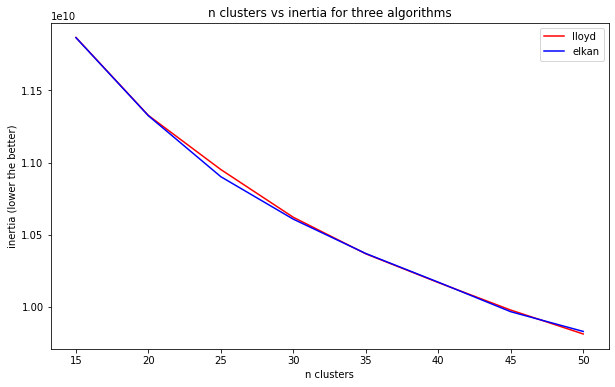

In [136]:
plt.figure(figsize=(10,6))
for algo,col in zip(kmeans_params['algorithm'],['red','blue','green']):
    result_lst = []
    for n in kmeans_params['n_clusters']:
        kmeans_tmp = KMeans(n_clusters=n,algorithm=algo).fit(x_train)
        result_lst.append(kmeans_tmp.inertia_)
    else:
        plt.plot(kmeans_params['n_clusters'],result_lst,c=col,label=algo)

plt.title('n clusters vs inertia for three algorithms')
plt.xlabel('n clusters')
plt.ylabel('inertia (lower the better)')
plt.legend()

As we can notice from the above graph that as the n_clusters increases, the inertia decreases.\
Notice that the inertia value is in a power of 10, which means the inertia only decreases marginally everytime n_clusters increases.\
In this case, we will select a comfortable value of n_clusters which does not give us prolonged computation time.

We can also notice that generally the blue line stays at the bottom of red line.\
Which also means the the algorithm 'elkan' always provide lower inertia than the default algorithm 'llyod', given the same n_clusters value.

> Best parameters:\
> n_clusters = 30\
> algorithm = elkan

Lets create our k-means model using the best found parameters

In [207]:
kmeans = KMeans(30).fit(x_train)

In [208]:
kmeans_yhat = kmeans.labels_

Lets see more details about the predicted outcomes

In [209]:
pd.DataFrame(kmeans_yhat).value_counts().sort_index()

0     132
1     152
2     180
3     170
4     259
5     191
6     186
7     160
8     171
9     237
10     99
11    166
12    207
13    119
14    209
15    127
16    127
17    143
18    143
19    112
20    280
21    248
22    102
23    136
24    158
25    197
26    156
27    146
28    159
29    128
dtype: int64

In [210]:
kmeans.inertia_

10611486045.36027

In [211]:
kmeans_centers = kmeans.cluster_centers_

Let's have a closer look at the means. Even though there are 10 digits, some of them are over/under-represented. Do you understand why?

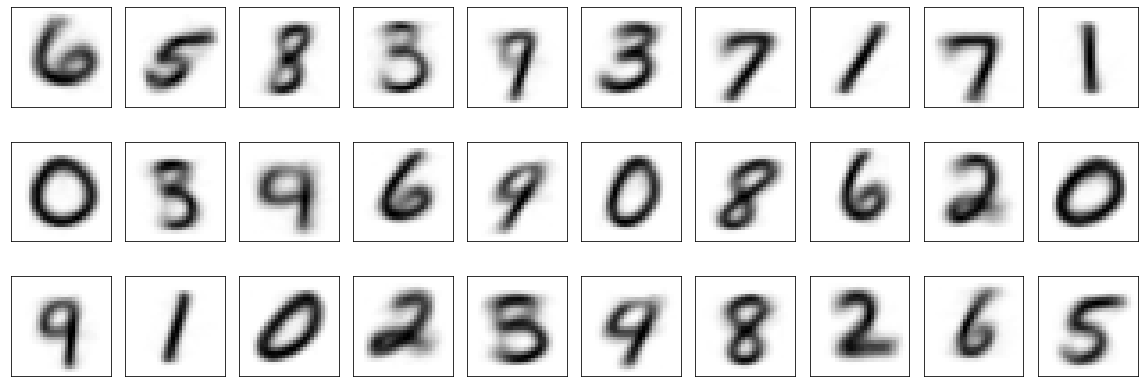

In [212]:
plt.figure(figsize=(16,6))
for i in range(int(2*(kmeans_centers.shape[0]/2))): # loop over all means
    plt.subplot(math.ceil(kmeans_centers.shape[0]/10),10,i+1)
    plt.imshow(kmeans_centers[i].reshape(28,28))
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()

Let's create a dictionary to tell which class of the clusters stands for which digit.\
This enables us to calculate a more readable accuracy value in the following section.

In [285]:
kmeans_labeldict = dict([(key,value) for key,value in zip(range(30),['6','5','8','3','7','3','7','1','7','1','0','3','4','6','4','0','8','6','2','0','9','1','0','2','5','4','8','2','6','5'])])

We need to first transform the yhat with the dictionary created from above

In [286]:
kmeans_yhat_train = np.asarray([kmeans_labeldict[i] for i in kmeans_yhat]).astype('int')
kmeans_yhat_train

array([2, 1, 9, ..., 1, 7, 1])

In [287]:
y_train

array([2, 1, 4, ..., 1, 4, 1], dtype=int64)

In [315]:
def scoring(x_pred,x_true):
    # score = sum([1 if pred == true else 0 for pred,true in zip(x_pred,x_true)])/x_pred.shape[0]
    df = pd.DataFrame({'pred':x_pred,'true':x_true}).query('pred != true').astype('str')
    df['comb'] = df['pred'] + ' -> '+ df['true'] 
    result = df['comb'].value_counts().sort_values(ascending=False).head(5)
    score = 1 - (df.shape[0]/x_pred.shape[0])
    return score,result

In [316]:
kmeans_score_train,kmeans_result_train = scoring(kmeans_yhat_train,y_train)

In [317]:
print('Score:',kmeans_score_train)
print('Result:')
print('pred -> true')
display(kmeans_result_train)

Score: 0.7418
Result:
pred -> true


4 -> 9    235
7 -> 9    110
3 -> 5    107
9 -> 4     97
5 -> 3     75
Name: comb, dtype: int64

We can see that there's a lot of error for 4,7 and 9, the accuracy is only 74%.\
From the preview of the cluster centers' images, we can notice that it is very difficult to segregate (4 and 9) and (7 and 9) due to how look-alike they are with each other.

Let's see its performance against the randomly picked test datasets of 1000 samples

In [291]:
kmeans_yhat_test = np.asarray([kmeans_labeldict[i] for i in kmeans.predict(x_test)]).astype('int')

In [318]:
kmeans_score_test,kmeans_result_test = scoring(kmeans_yhat_test,y_test)

In [319]:
print('Score:',kmeans_score_test)
print('Result:')
print('pred -> true')
display(kmeans_result_test)

Score: 0.716
Result:
pred -> true


4 -> 9    55
3 -> 5    29
7 -> 9    23
9 -> 4    19
5 -> 3    18
Name: comb, dtype: int64

The K-Means model has only 71.6% at predicting randomly picked testing datasets of 1000 samples.\
This could be due to the problem of recognizing hand written digits are not suitable to be solved by a clustering approach.

### Export the model

We will use pd.to_pickle to export the trained model as pickle file, so we can reuse the trained model next time without retraining

In [325]:
pd.to_pickle(kmeans,"Trained Models\\kmeans.pkl")

# Classification Approach

Now we will try to address the same problem with classification approach

## 1. K-Nearest Neighbors Algorithm

The first model we are going to try is the K-Nearest Neighbors model

In [124]:
knn_params = {
    "n_neighbors" : (3,5,7,9,11)
}

In [125]:
knn = KNeighborsClassifier()

In [126]:
knn_cv = GridSearchCV(knn,knn_params,return_train_score=True)

In [127]:
knn_cv.fit(x_train,y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': (3, 5, 7, 9, 11)},
             return_train_score=True)

C:\Users\pi314\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


<Figure size 720x432 with 0 Axes>

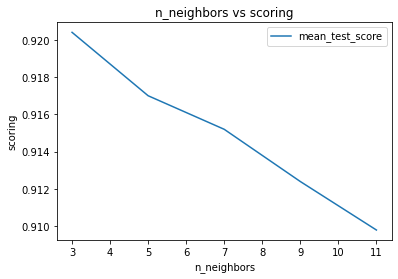

In [131]:
plt.figure(figsize=(10,6))
pd.DataFrame(knn_cv.cv_results_).plot('param_n_neighbors','mean_test_score')
plt.title("n_neighbors vs scoring")
plt.xlabel("n_neighbors")
plt.ylabel("scoring")
plt.show()

In [440]:
knn_cv.best_params_

{'n_neighbors': 3}

As we can see the K-Nearest Neighbors model performs the best at n_neighbors = 3.\
Although the graph shows that there could be better performance for n_neighbors < 3,\
but I believe that selecting too less n_neighbors is not a good choice as it could lead to biased trained model.

So we will use **n_neighbors = 3**

In [297]:
knn = KNeighborsClassifier(3).fit(x_train,y_train)

In [305]:
knn_yhat_train = knn.predict(x_train)

In [306]:
knn_yhat_train

array([2, 1, 4, ..., 1, 4, 1], dtype=int64)

In [307]:
y_train

array([2, 1, 4, ..., 1, 4, 1], dtype=int64)

In [320]:
knn_score_train,knn_result_train = scoring(knn_yhat_train,y_train)

In [321]:
print('Score:',knn_score_train)
print('Result:')
print('pred -> true')
display(knn_result_train)

Score: 0.9618
Result:
pred -> true


1 -> 8    14
1 -> 2    11
4 -> 8    10
3 -> 8     9
9 -> 4     9
Name: comb, dtype: int64

The accuracy at predicting the train dataset is as high as 96.2%

Let's see what's its performance with the test dataset

In [310]:
knn_yhat_test = knn.predict(x_test)

In [311]:
knn_yhat_test

array([6, 2, 7, 5, 7, 6, 3, 5, 1, 3, 1, 2, 5, 3, 6, 1, 0, 9, 4, 3, 1, 5,
       8, 3, 4, 7, 3, 6, 3, 1, 6, 9, 2, 1, 1, 0, 9, 3, 4, 1, 5, 1, 7, 1,
       4, 3, 5, 7, 7, 0, 0, 7, 0, 0, 1, 3, 7, 7, 4, 3, 5, 1, 7, 0, 5, 9,
       4, 1, 1, 1, 1, 1, 0, 3, 1, 9, 3, 7, 6, 4, 9, 2, 3, 8, 7, 0, 2, 1,
       6, 9, 6, 5, 1, 6, 7, 8, 4, 6, 0, 0, 8, 9, 0, 6, 2, 1, 0, 9, 6, 1,
       1, 0, 9, 3, 8, 1, 2, 9, 0, 5, 9, 1, 4, 4, 3, 8, 3, 2, 1, 7, 1, 2,
       3, 6, 4, 1, 1, 9, 1, 8, 2, 2, 1, 7, 1, 9, 9, 9, 5, 9, 9, 9, 9, 3,
       4, 8, 2, 9, 0, 0, 9, 1, 6, 4, 5, 1, 1, 6, 7, 8, 2, 7, 8, 2, 7, 2,
       7, 0, 1, 7, 9, 3, 5, 0, 2, 2, 9, 1, 0, 9, 1, 9, 4, 7, 5, 1, 0, 2,
       6, 3, 2, 1, 4, 8, 6, 4, 4, 3, 6, 3, 3, 7, 1, 4, 2, 9, 9, 0, 1, 8,
       4, 3, 3, 0, 9, 2, 5, 7, 9, 9, 9, 5, 6, 1, 5, 2, 0, 9, 4, 2, 1, 5,
       7, 1, 3, 5, 7, 1, 0, 7, 4, 1, 7, 0, 5, 0, 7, 1, 5, 6, 8, 6, 9, 1,
       0, 4, 9, 3, 5, 0, 8, 1, 9, 8, 6, 1, 9, 9, 3, 7, 8, 7, 2, 9, 0, 9,
       9, 0, 6, 2, 1, 4, 3, 3, 4, 0, 9, 6, 2, 3, 6,

In [312]:
y_test

array([6, 2, 7, 5, 7, 6, 3, 5, 1, 3, 1, 2, 5, 3, 6, 1, 0, 9, 4, 3, 1, 5,
       8, 3, 4, 7, 3, 6, 5, 1, 6, 9, 2, 1, 1, 0, 7, 3, 4, 1, 5, 1, 7, 1,
       4, 9, 5, 7, 7, 0, 0, 7, 0, 0, 1, 3, 9, 7, 4, 3, 5, 1, 7, 8, 5, 9,
       4, 0, 7, 1, 1, 1, 0, 3, 1, 9, 3, 7, 6, 4, 9, 2, 3, 8, 7, 0, 2, 2,
       6, 9, 6, 5, 1, 6, 7, 8, 4, 6, 8, 0, 8, 7, 0, 6, 2, 1, 0, 9, 6, 1,
       1, 0, 9, 3, 8, 1, 2, 9, 0, 5, 9, 1, 4, 4, 3, 8, 3, 2, 1, 7, 1, 2,
       3, 6, 4, 1, 7, 9, 5, 8, 2, 2, 8, 7, 1, 9, 9, 9, 5, 4, 9, 9, 9, 3,
       4, 8, 2, 9, 5, 0, 9, 1, 6, 4, 5, 1, 7, 6, 7, 8, 2, 7, 8, 2, 2, 2,
       7, 0, 1, 7, 9, 3, 5, 0, 2, 2, 9, 1, 0, 9, 1, 9, 4, 7, 5, 1, 0, 2,
       6, 3, 2, 1, 4, 8, 6, 4, 4, 3, 6, 3, 3, 7, 1, 8, 2, 9, 9, 0, 1, 8,
       4, 3, 3, 0, 9, 2, 5, 7, 9, 9, 9, 5, 6, 1, 5, 2, 0, 9, 4, 2, 1, 5,
       7, 1, 3, 5, 7, 1, 0, 7, 4, 1, 7, 0, 5, 0, 7, 1, 5, 5, 8, 6, 9, 1,
       0, 4, 9, 9, 5, 0, 8, 1, 9, 8, 6, 1, 9, 2, 3, 7, 8, 7, 2, 4, 3, 4,
       9, 0, 6, 2, 1, 4, 3, 3, 4, 0, 9, 6, 2, 3, 6,

In [322]:
knn_score_test,knn_result_test = scoring(knn_yhat_test,y_test)

In [323]:
print('Score:',knn_score_test)
print('Result:')
print('pred -> true')
display(knn_result_test)

Score: 0.935
Result:
pred -> true


9 -> 4    8
1 -> 7    6
5 -> 8    4
1 -> 8    4
7 -> 2    4
Name: comb, dtype: int64

With the test dataset, the model still has 93.5% of accuracy

### Export the model

We will use pd.to_pickle to export the trained model as pickle file, so we can reuse the trained model next time without retraining

In [339]:
pd.to_pickle(knn,"Trained Models\\knn.pkl")

## 2. Support Vector Machines

In [366]:
svc_params = {
    "C" : (0.001,0.01,0.1,1,10,100,1000),
    "kernel" : ('linear', 'poly', 'rbf', 'sigmoid'),
    "degree" : (3,4,5,6),
}

In [342]:
svc = SVC()

In [367]:
svc_cv = GridSearchCV(svc,svc_params,n_jobs=4)

In [368]:
svc_cv.fit(x_train,y_train)

GridSearchCV(estimator=SVC(), n_jobs=4,
             param_grid={'C': (0.001, 0.01, 0.1, 1, 10, 100, 1000),
                         'degree': (3, 4, 5, 6),
                         'kernel': ('linear', 'poly', 'rbf', 'sigmoid')})

In [369]:
svc_cv_results = pd.DataFrame(svc_cv.cv_results_)
svc_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.410041,0.060344,1.132747,0.041520,0.001,3,linear,"{'C': 0.001, 'degree': 3, 'kernel': 'linear'}",0.902,0.871,0.902,0.888,0.901,0.8928,0.012123,29
1,26.409186,0.260404,2.871330,0.147789,0.001,3,poly,"{'C': 0.001, 'degree': 3, 'kernel': 'poly'}",0.120,0.127,0.124,0.122,0.121,0.1228,0.002482,104
2,26.025458,0.465895,4.097531,0.495500,0.001,3,rbf,"{'C': 0.001, 'degree': 3, 'kernel': 'rbf'}",0.118,0.118,0.118,0.119,0.119,0.1184,0.000490,105
3,26.339953,0.248233,2.875876,0.161995,0.001,3,sigmoid,"{'C': 0.001, 'degree': 3, 'kernel': 'sigmoid'}",0.118,0.118,0.118,0.119,0.119,0.1184,0.000490,105
4,3.454436,0.094968,1.088933,0.037220,0.001,4,linear,"{'C': 0.001, 'degree': 4, 'kernel': 'linear'}",0.902,0.871,0.902,0.888,0.901,0.8928,0.012123,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,2.788039,0.124296,0.908700,0.051254,1000,5,sigmoid,"{'C': 1000, 'degree': 5, 'kernel': 'sigmoid'}",0.742,0.742,0.754,0.750,0.767,0.7510,0.009252,83
108,3.534145,0.101647,1.112151,0.046366,1000,6,linear,"{'C': 1000, 'degree': 6, 'kernel': 'linear'}",0.902,0.871,0.902,0.888,0.901,0.8928,0.012123,29
109,7.178198,0.187020,1.214287,0.040966,1000,6,poly,"{'C': 1000, 'degree': 6, 'kernel': 'poly'}",0.844,0.828,0.857,0.846,0.883,0.8516,0.018227,65
110,5.718025,0.224416,2.118683,0.131378,1000,6,rbf,"{'C': 1000, 'degree': 6, 'kernel': 'rbf'}",0.944,0.944,0.954,0.946,0.951,0.9478,0.004020,1


C:\Users\pi314\AppData\Local\Temp\ipykernel_11148\4113175257.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.loc[:,'xticks'] = df_tmp['param_C'].copy().astype('str') + ', ' + df_tmp['param_degree'].copy().astype('str')
C:\Users\pi314\AppData\Local\Temp\ipykernel_11148\4113175257.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.loc[:,'xticks'] = df_tmp['param_C'].copy().astype('str') + ', ' + df_tmp['param_degree'].copy().astype('str')
C:\Users\pi314\AppData\Local\Temp\ipykernel_11148\41

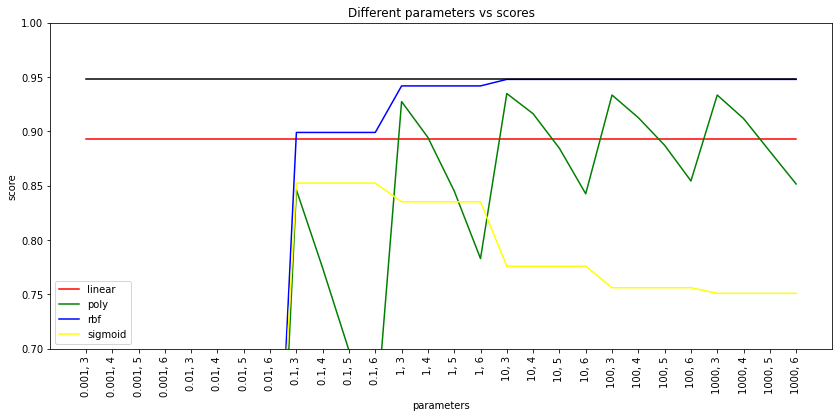

In [420]:
plt.figure(figsize=(14,6))
for kern,col in zip(svc_params['kernel'],['red','green','blue','yellow']):
    df_tmp = svc_cv_results.query(f'param_kernel == "{kern}"')
    df_tmp.loc[:,'xticks'] = df_tmp['param_C'].copy().astype('str') + ', ' + df_tmp['param_degree'].copy().astype('str')
    plt.plot(df_tmp['xticks'],df_tmp['mean_test_score'],color=col,label=kern)

plt.plot(df_tmp['xticks'],[svc_cv_results['mean_test_score'].max() for i in range(df_tmp.shape[0])],color='k')
plt.xticks(rotation=90)
plt.title('Different parameters vs scores')
plt.xlabel('parameters')
plt.ylabel('score')
plt.ylim((0.7,1.0))
plt.legend(svc_params['kernel'])
plt.show()

In [439]:
svc_cv.best_params_

{'C': 10, 'degree': 3, 'kernel': 'rbf'}

From the line plot above, we can see that the best parameters are C >= 10 and degree doesn't affect the score for the kernel = 'rbf'.

>Best parameters:\
>kernel: rbf\
>C: 10

In [421]:
svc = SVC(C=10,kernel='rbf').fit(x_train,y_train)

In [422]:
svc_yhat_train = svc.predict(x_train)
svc_yhat_train

array([2, 1, 4, ..., 1, 4, 1], dtype=int64)

In [423]:
y_train

array([2, 1, 4, ..., 1, 4, 1], dtype=int64)

In [424]:
svc_score_train,svc_result_train = scoring(svc_yhat_train,y_train)

In [425]:
print('Score:',svc_score_train)
print('Result:')
print('pred -> true')
display(svc_result_train)

Score: 1.0
Result:
pred -> true


Series([], Name: comb, dtype: int64)

It seems like Support Vector Machine have 100% accuracy at predicting training dataset

Let's see what's its performance against the test dataset

In [426]:
svc_yhat_test = svc.predict(x_test)
svc_yhat_test

array([6, 2, 7, 5, 7, 6, 3, 5, 1, 3, 1, 2, 5, 3, 6, 1, 0, 9, 4, 3, 1, 5,
       8, 3, 4, 7, 3, 6, 5, 1, 6, 9, 2, 1, 1, 0, 9, 3, 4, 1, 5, 1, 5, 1,
       4, 3, 5, 7, 7, 0, 0, 7, 0, 0, 1, 3, 0, 7, 4, 3, 5, 1, 7, 2, 5, 9,
       4, 8, 7, 1, 1, 1, 0, 3, 1, 9, 3, 7, 6, 4, 9, 2, 3, 8, 7, 0, 2, 2,
       6, 9, 6, 5, 1, 6, 7, 8, 4, 6, 8, 0, 8, 4, 0, 6, 2, 1, 0, 9, 6, 1,
       1, 0, 9, 8, 8, 1, 2, 9, 3, 5, 9, 1, 4, 4, 3, 8, 3, 2, 1, 7, 1, 4,
       3, 6, 4, 1, 7, 9, 1, 8, 2, 2, 5, 7, 1, 9, 9, 9, 5, 4, 9, 9, 9, 3,
       4, 8, 2, 9, 0, 0, 9, 1, 6, 4, 5, 1, 7, 6, 7, 8, 2, 7, 8, 2, 2, 2,
       7, 0, 1, 7, 9, 3, 5, 0, 2, 2, 9, 1, 0, 9, 1, 9, 4, 7, 5, 1, 0, 2,
       6, 3, 2, 1, 4, 8, 6, 4, 4, 3, 6, 3, 3, 7, 1, 4, 2, 9, 9, 0, 1, 8,
       4, 3, 3, 0, 9, 2, 5, 7, 7, 9, 9, 5, 6, 1, 5, 2, 0, 9, 4, 2, 1, 5,
       8, 1, 3, 5, 7, 1, 0, 7, 4, 1, 7, 0, 5, 0, 7, 1, 5, 6, 8, 6, 9, 1,
       0, 4, 9, 9, 5, 0, 8, 1, 9, 8, 6, 1, 9, 2, 3, 7, 8, 7, 2, 4, 3, 4,
       9, 0, 6, 2, 1, 4, 3, 3, 4, 0, 9, 6, 2, 3, 6,

In [427]:
y_test

array([6, 2, 7, 5, 7, 6, 3, 5, 1, 3, 1, 2, 5, 3, 6, 1, 0, 9, 4, 3, 1, 5,
       8, 3, 4, 7, 3, 6, 5, 1, 6, 9, 2, 1, 1, 0, 7, 3, 4, 1, 5, 1, 7, 1,
       4, 9, 5, 7, 7, 0, 0, 7, 0, 0, 1, 3, 9, 7, 4, 3, 5, 1, 7, 8, 5, 9,
       4, 0, 7, 1, 1, 1, 0, 3, 1, 9, 3, 7, 6, 4, 9, 2, 3, 8, 7, 0, 2, 2,
       6, 9, 6, 5, 1, 6, 7, 8, 4, 6, 8, 0, 8, 7, 0, 6, 2, 1, 0, 9, 6, 1,
       1, 0, 9, 3, 8, 1, 2, 9, 0, 5, 9, 1, 4, 4, 3, 8, 3, 2, 1, 7, 1, 2,
       3, 6, 4, 1, 7, 9, 5, 8, 2, 2, 8, 7, 1, 9, 9, 9, 5, 4, 9, 9, 9, 3,
       4, 8, 2, 9, 5, 0, 9, 1, 6, 4, 5, 1, 7, 6, 7, 8, 2, 7, 8, 2, 2, 2,
       7, 0, 1, 7, 9, 3, 5, 0, 2, 2, 9, 1, 0, 9, 1, 9, 4, 7, 5, 1, 0, 2,
       6, 3, 2, 1, 4, 8, 6, 4, 4, 3, 6, 3, 3, 7, 1, 8, 2, 9, 9, 0, 1, 8,
       4, 3, 3, 0, 9, 2, 5, 7, 9, 9, 9, 5, 6, 1, 5, 2, 0, 9, 4, 2, 1, 5,
       7, 1, 3, 5, 7, 1, 0, 7, 4, 1, 7, 0, 5, 0, 7, 1, 5, 5, 8, 6, 9, 1,
       0, 4, 9, 9, 5, 0, 8, 1, 9, 8, 6, 1, 9, 2, 3, 7, 8, 7, 2, 4, 3, 4,
       9, 0, 6, 2, 1, 4, 3, 3, 4, 0, 9, 6, 2, 3, 6,

In [428]:
svc_score_test,svc_result_test = scoring(svc_yhat_test,y_test)

In [429]:
print('Score:',svc_score_test)
print('Result:')
print('pred -> true')
display(svc_result_test)

Score: 0.956
Result:
pred -> true


9 -> 4    4
9 -> 7    3
7 -> 9    2
3 -> 9    2
8 -> 3    2
Name: comb, dtype: int64

It has 95.6% accuracy against the test dataset of 1000 samples

### Export the model

We will use pd.to_pickle to export the trained model as pickle file, so we can reuse the trained model next time without retraining

In [430]:
pd.to_pickle(knn,"Trained Models\\svc.pkl")

## 3. Naive Bayes

In [434]:
nb_params = {
    "alpha" : (0.01,0.1,10,100)
}

In [435]:
nb = CategoricalNB()

In [436]:
nb_cv = GridSearchCV(nb,nb_params,n_jobs=2)

In [437]:
nb_cv.fit(x_train,y_train)

C:\Users\pi314\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(


GridSearchCV(estimator=CategoricalNB(), n_jobs=2,
             param_grid={'alpha': (0.01, 0.1, 10, 100)})

In [444]:
nb_cv.cv_results_

{'mean_fit_time': array([0.50446415, 0.47636971, 0.45633602, 0.48887501]),
 'std_fit_time': array([0.02907377, 0.03969251, 0.01523372, 0.03894636]),
 'mean_score_time': array([0.01280122, 0.00412617, 0.00219913, 0.00552521]),
 'std_score_time': array([0.00874981, 0.00606942, 0.00271156, 0.0057551 ]),
 'param_alpha': masked_array(data=[0.01, 0.1, 10, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.01}, {'alpha': 0.1}, {'alpha': 10}, {'alpha': 100}],
 'split0_test_score': array([nan, nan, nan, nan]),
 'split1_test_score': array([nan, nan, nan, nan]),
 'split2_test_score': array([nan, nan, nan, nan]),
 'split3_test_score': array([nan, nan, nan, nan]),
 'split4_test_score': array([nan, nan, nan, nan]),
 'mean_test_score': array([nan, nan, nan, nan]),
 'std_test_score': array([nan, nan, nan, nan]),
 'rank_test_score': array([1, 2, 3, 4])}

As we can see that the grid search actually failed to provide scoring of instances with different parameters, we will use our own method to rank the different parameters

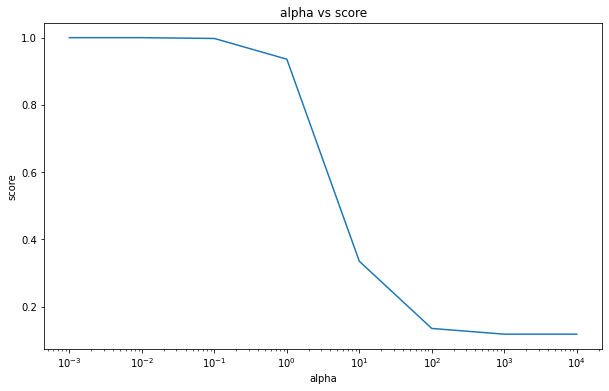

In [451]:
alphas = [0.001,0.01,0.1,1,10,100,1000,10000]
scores = []
for alpha in alphas:
    score,result = scoring(CategoricalNB(alpha=alpha).fit(x_train,y_train).predict(x_train),y_train)
    scores.append(score)
plt.figure(figsize=(10,6))
plt.plot(alphas,scores)
plt.title('alpha vs score')
plt.xlabel('alpha')
plt.ylabel('score')
plt.xscale('log')
plt.show()

In [453]:
nb_result = pd.DataFrame({'alpha':alphas,'score':scores})

In [458]:
nb_result.query('score == @nb_result["score"].max()')

,alpha,score
0,0.001,1.0
1,0.010,1.0


As we can see from the results shown above, the Naive Bayes model performs the best at alpha = 0.001 or 0.01.
We will select either one to continue.

>Best parameter:\
>alpha: 0.01

In [514]:
nb = CategoricalNB(alpha=0.01,min_categories=[256 for i in range(x_train.shape[1])]).fit(x_train,y_train)

In [520]:
for i in range(1000):
    try:
        nb.predict(x_test[i].reshape((1,-1)))
    except:
        print(i)
        continue

In [521]:
nb_yhat_test = nb.predict(x_test)
nb_yhat_test

array([6, 2, 4, 5, 7, 6, 3, 5, 1, 5, 1, 5, 5, 3, 6, 1, 0, 9, 4, 3, 1, 8,
       8, 3, 4, 7, 3, 5, 5, 1, 6, 8, 2, 8, 1, 0, 9, 3, 4, 1, 8, 1, 4, 1,
       4, 3, 3, 7, 7, 0, 0, 2, 0, 0, 1, 3, 0, 7, 4, 3, 3, 1, 7, 8, 7, 9,
       2, 8, 9, 1, 1, 1, 0, 3, 1, 9, 3, 7, 6, 4, 9, 3, 3, 8, 7, 0, 2, 2,
       6, 9, 1, 5, 1, 6, 7, 8, 4, 6, 8, 0, 8, 9, 0, 3, 2, 1, 5, 9, 6, 1,
       1, 5, 9, 4, 8, 1, 5, 9, 3, 8, 9, 1, 4, 4, 3, 8, 3, 2, 1, 8, 1, 4,
       3, 6, 4, 1, 1, 9, 1, 9, 2, 2, 9, 7, 2, 7, 0, 9, 5, 9, 9, 4, 9, 3,
       4, 8, 2, 9, 3, 0, 9, 1, 6, 6, 5, 1, 1, 6, 7, 1, 2, 7, 9, 8, 8, 3,
       9, 0, 1, 9, 9, 5, 5, 0, 2, 2, 9, 1, 0, 9, 1, 9, 9, 7, 5, 1, 0, 2,
       6, 3, 2, 1, 4, 8, 6, 4, 9, 3, 6, 3, 3, 7, 1, 8, 2, 9, 9, 0, 1, 8,
       9, 3, 3, 0, 9, 2, 5, 7, 7, 9, 9, 5, 6, 1, 5, 2, 0, 4, 4, 2, 1, 8,
       8, 1, 3, 3, 7, 1, 0, 7, 4, 1, 9, 0, 3, 0, 9, 1, 3, 6, 8, 6, 8, 1,
       0, 9, 9, 9, 8, 0, 8, 1, 4, 8, 6, 1, 9, 8, 3, 9, 0, 7, 8, 4, 2, 9,
       9, 0, 6, 2, 1, 4, 3, 3, 4, 0, 9, 6, 4, 3, 6,

In [522]:
y_test

array([6, 2, 7, 5, 7, 6, 3, 5, 1, 3, 1, 2, 5, 3, 6, 1, 0, 9, 4, 3, 1, 5,
       8, 3, 4, 7, 3, 6, 5, 1, 6, 9, 2, 1, 1, 0, 7, 3, 4, 1, 5, 1, 7, 1,
       4, 9, 5, 7, 7, 0, 0, 7, 0, 0, 1, 3, 9, 7, 4, 3, 5, 1, 7, 8, 5, 9,
       4, 0, 7, 1, 1, 1, 0, 3, 1, 9, 3, 7, 6, 4, 9, 2, 3, 8, 7, 0, 2, 2,
       6, 9, 6, 5, 1, 6, 7, 8, 4, 6, 8, 0, 8, 7, 0, 6, 2, 1, 0, 9, 6, 1,
       1, 0, 9, 3, 8, 1, 2, 9, 0, 5, 9, 1, 4, 4, 3, 8, 3, 2, 1, 7, 1, 2,
       3, 6, 4, 1, 7, 9, 5, 8, 2, 2, 8, 7, 1, 9, 9, 9, 5, 4, 9, 9, 9, 3,
       4, 8, 2, 9, 5, 0, 9, 1, 6, 4, 5, 1, 7, 6, 7, 8, 2, 7, 8, 2, 2, 2,
       7, 0, 1, 7, 9, 3, 5, 0, 2, 2, 9, 1, 0, 9, 1, 9, 4, 7, 5, 1, 0, 2,
       6, 3, 2, 1, 4, 8, 6, 4, 4, 3, 6, 3, 3, 7, 1, 8, 2, 9, 9, 0, 1, 8,
       4, 3, 3, 0, 9, 2, 5, 7, 9, 9, 9, 5, 6, 1, 5, 2, 0, 9, 4, 2, 1, 5,
       7, 1, 3, 5, 7, 1, 0, 7, 4, 1, 7, 0, 5, 0, 7, 1, 5, 5, 8, 6, 9, 1,
       0, 4, 9, 9, 5, 0, 8, 1, 9, 8, 6, 1, 9, 2, 3, 7, 8, 7, 2, 4, 3, 4,
       9, 0, 6, 2, 1, 4, 3, 3, 4, 0, 9, 6, 2, 3, 6,

In [523]:
nb_score_test,nb_result_test = scoring(nb_yhat_test,y_test)

In [524]:
print('Score:',nb_score_test)
print('Result:')
print('pred -> true')
display(nb_result_test)

Score: 0.761
Result:
pred -> true


9 -> 4    24
9 -> 7    18
3 -> 5    17
8 -> 2    14
8 -> 5    13
Name: comb, dtype: int64

Although this Naive Bayes model has 100% accuracy against the training dataset, but when it comes to test dataset, it only gives 76.1% accuracy.\
There might be a possibility where the accuracy can increase if we give more samples as training data, but this also applies the same to other machine learning model as well.

### Export the model

We will use pd.to_pickle to export the trained model as pickle file, so we can reuse the trained model next time without retraining

In [567]:
pd.to_pickle(knn,"Trained Models\\nb.pkl")

# Conclusion

Results:

In [527]:
models = ['KMeans','KNN','SVM','Naive Bayes']
final_scores = [kmeans_score_test,knn_score_test,svc_score_test,nb_score_test]
final_results = pd.DataFrame({'model':models,'score':final_scores})
display(final_results.sort_values('score',ascending=False))

,model,score
2,SVM,0.956
1,KNN,0.935
3,Naive Bayes,0.761
0,KMeans,0.716


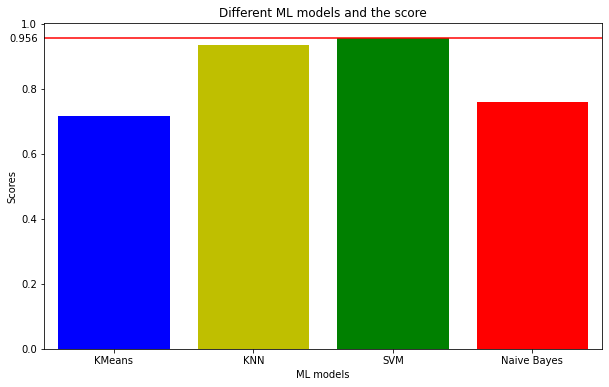

In [566]:
plt.figure(figsize=(10,6))
plt.bar(models,final_scores,color=['b','y','g','r'])
plt.plot([-0.5,3.5],[max(final_scores) for i in range(2)],c='r')
plt.text(-0.75,max(final_scores)-0.01,max(final_scores))
plt.title("Different ML models and the score")
plt.xlabel("ML models")
plt.ylabel("Scores")
plt.xlim(-0.5,3.5)
plt.show()

As such, we have high confidence to believe that SVM is the best model for addressing this problem of recognizing hand written digits.